# 사람의 동작 분류
- 핸드폰 센서 데이터 분류 (GPU 사용 권장)
- 선형 모델, 랜덤포레스트, MLP, CNN 비교

# import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import zipfile
from scipy import stats
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, LSTM
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.utils import to_categorical
%config InlineBackend.figure_format = 'retina'

# 데이터
- 사람 행동 데이터 다운로드

In [2]:
!curl https://raw.githubusercontent.com/StillWork/data/master/smartphone.zip\
    -o smartphone.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.4M  100 10.4M    0     0  19.4M      0 --:--:-- --:--:-- --:--:-- 19.4M


In [3]:
# 압축 풀기
with zipfile.ZipFile("smartphone.zip", 'r') as z:
    print(z.namelist())
    z.extractall()

['smartphone.txt']


## 데이터 전처리

In [4]:
column_names = ['user-id', 'activity', 'timestamp', 'x-axis',
                'y-axis', 'z-axis']   #Column Name 지정
df = pd.read_csv('smartphone.txt', header=None, names=column_names)
print(df.shape)  #Data는 10086475 개, Column은 6개
df[:3]

(1086475, 6)


,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.50395286;
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;


In [ ]:
df.info()    #z-axis가 숫자가 아니라 문자로 취급하고 있음. 왜냐면 끝에 세미콜롬(;)이 붙어있어서. 그래서 밑에서 ; 를 제거(replace)하고 이를 숫자로 바꿔줌.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1086475 entries, 0 to 1086474
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user-id    1086475 non-null  int64  
 1   activity   1086475 non-null  object 
 2   timestamp  1086475 non-null  int64  
 3   x-axis     1086475 non-null  float64
 4   y-axis     1086475 non-null  float64
 5   z-axis     1086475 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 49.7+ MB


In [6]:
# z-컬럼의 ';'를 삭제하고 문자열 타입을 숫자 타입으로 변경한다
df['z-axis'].replace(regex=True,inplace=True, to_replace=r';', value=r'')  #; 를 제거(replace)하고
df['z-axis'] = df['z-axis'].apply(float)  #이를 숫자로 바꿔줌.
df[:3]

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722


<Axes: >

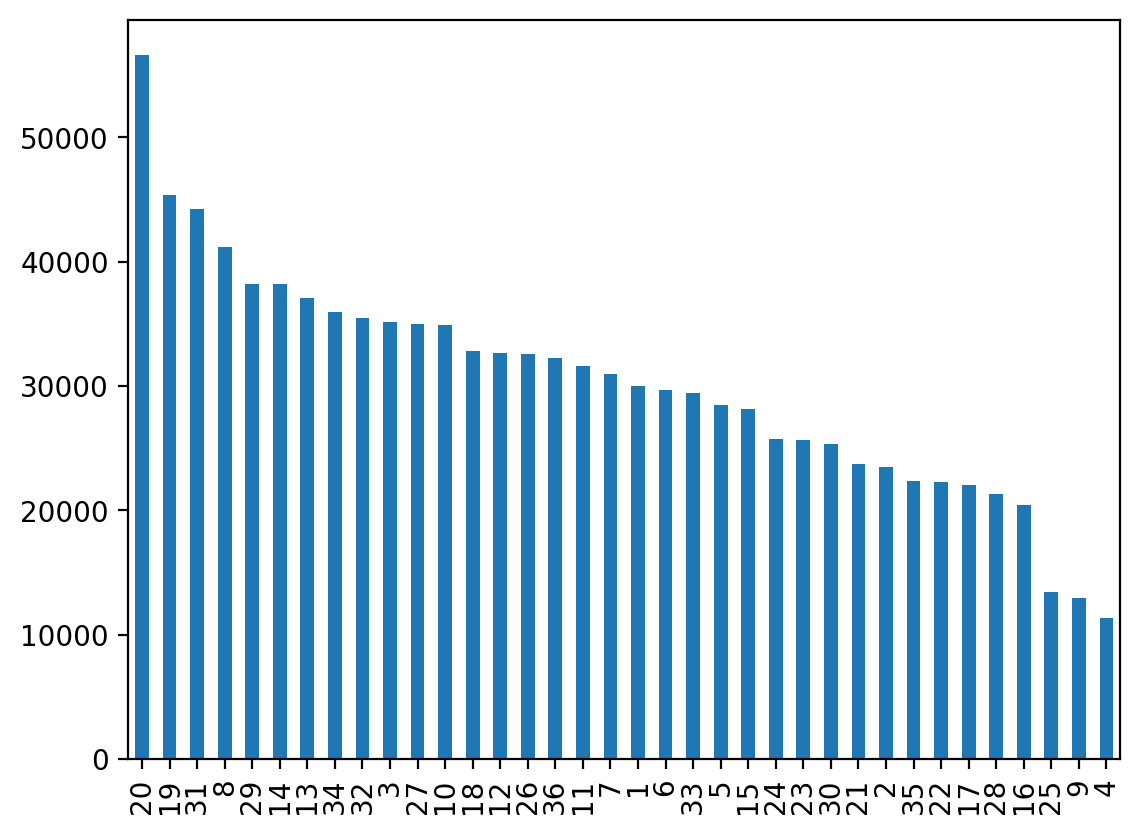

In [7]:
# 사용자별 데이터 수집량 보기
df['user-id'].value_counts().plot(kind='bar')  #사용자별(User-id))별로 몇개 의 데이터를 뽑았는지.

In [ ]:
df["user-id"].nunique()  #사용자 id가 Unique 하게 몇 개인지 찾아줌.

36

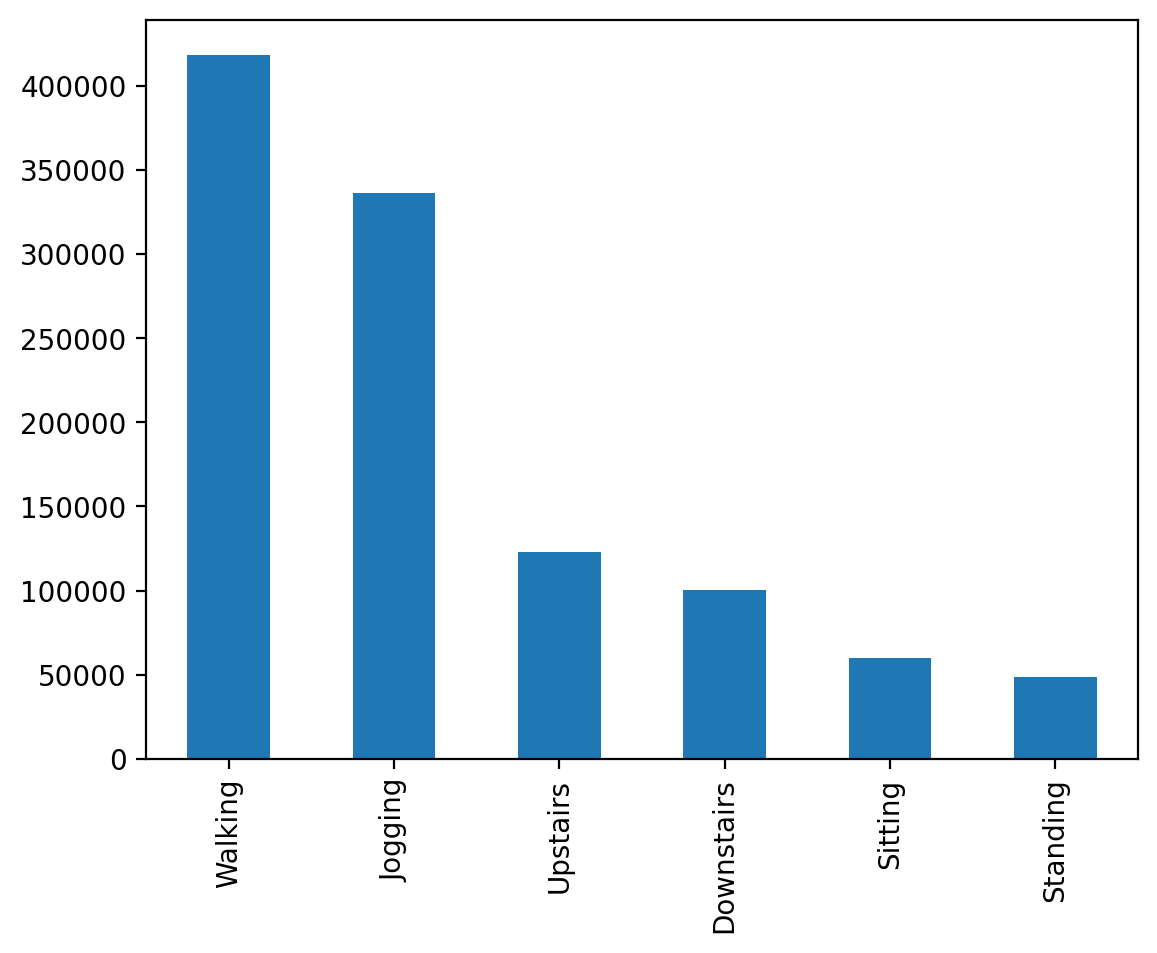

In [ ]:
df['activity'].value_counts().plot(kind='bar')  #Activity 컬럼에 대해서 Value count를 해서 몇 종류의 값이 얼마나 있는지 확인.
#value_count까지 하면 숫자만 나옴
#뒤에 plot을 뭍이면 막대그래프가 나옴.
plt.show()

<Axes: >

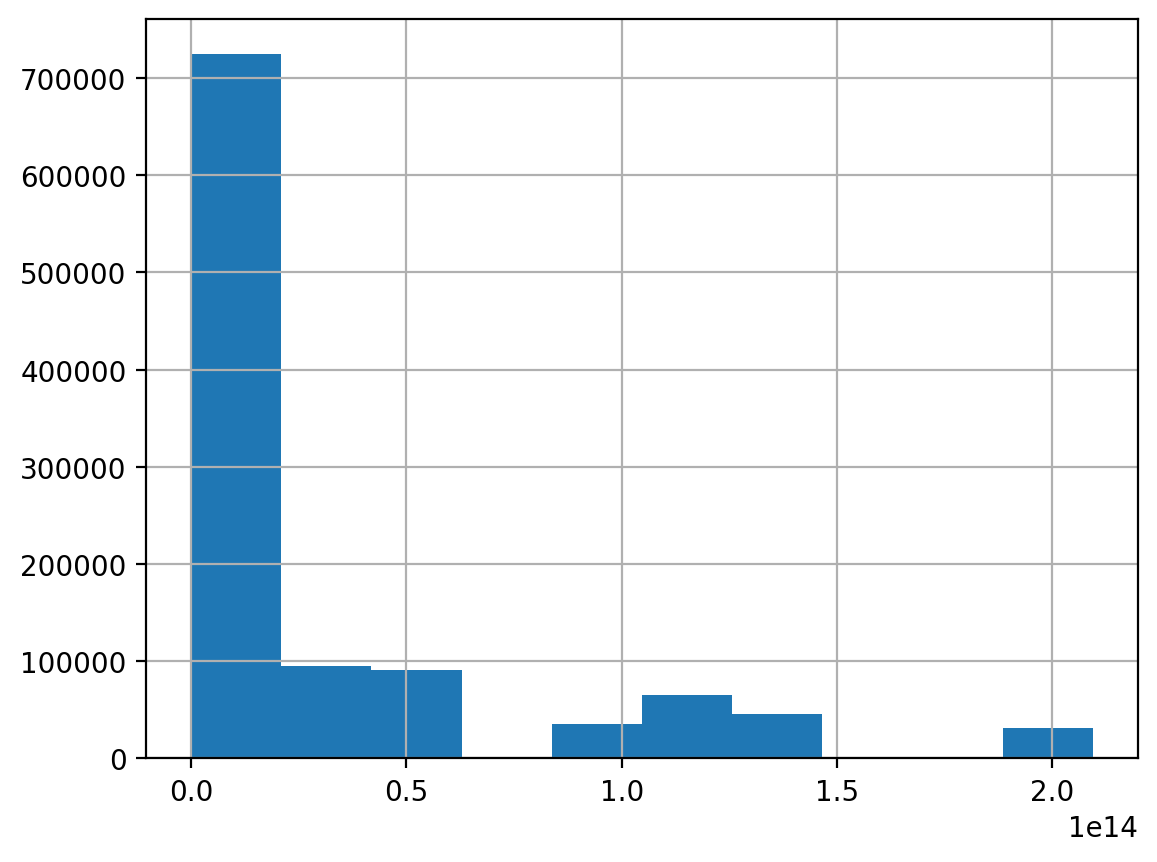

In [8]:
df['timestamp'].hist()  #timestamp 가 0 인게 있음..

In [ ]:
(df['timestamp'] == 0).sum()   #timestamp 가 0 인게 있음.. 갯수가 12845개

12845

In [9]:
# 시각이 0 이거나 음수인 샘플은 제외 (양수인 값만 사용)
print(df.shape)
df = df[df['timestamp'] > 0]
df.shape

(1086475, 6)


(1073630, 6)

## 데이터 시각화

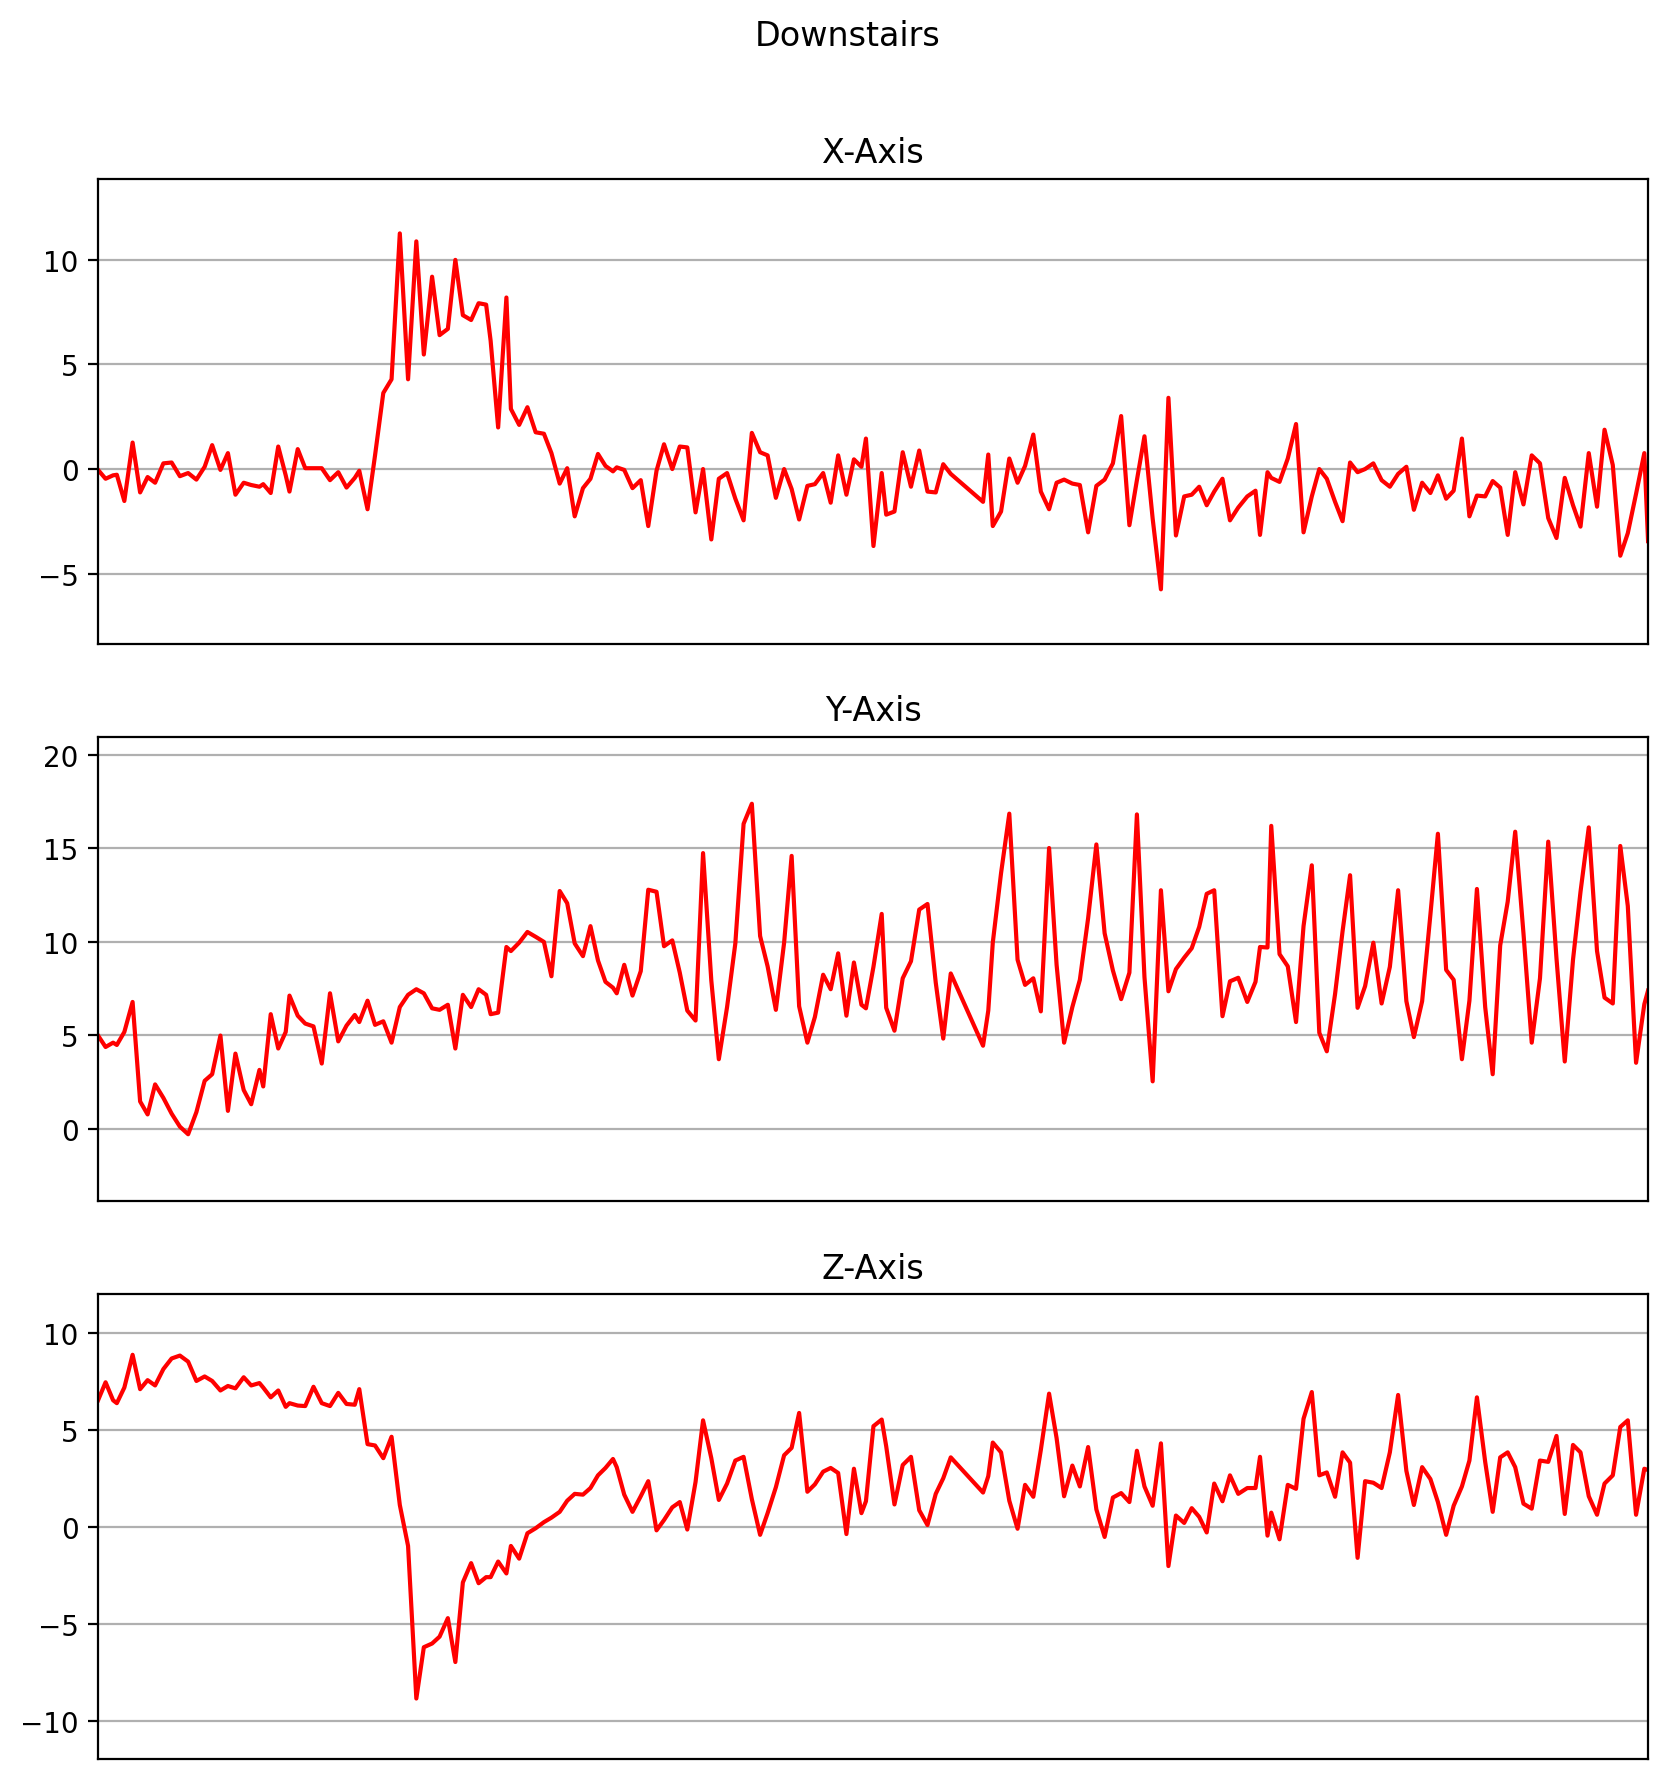

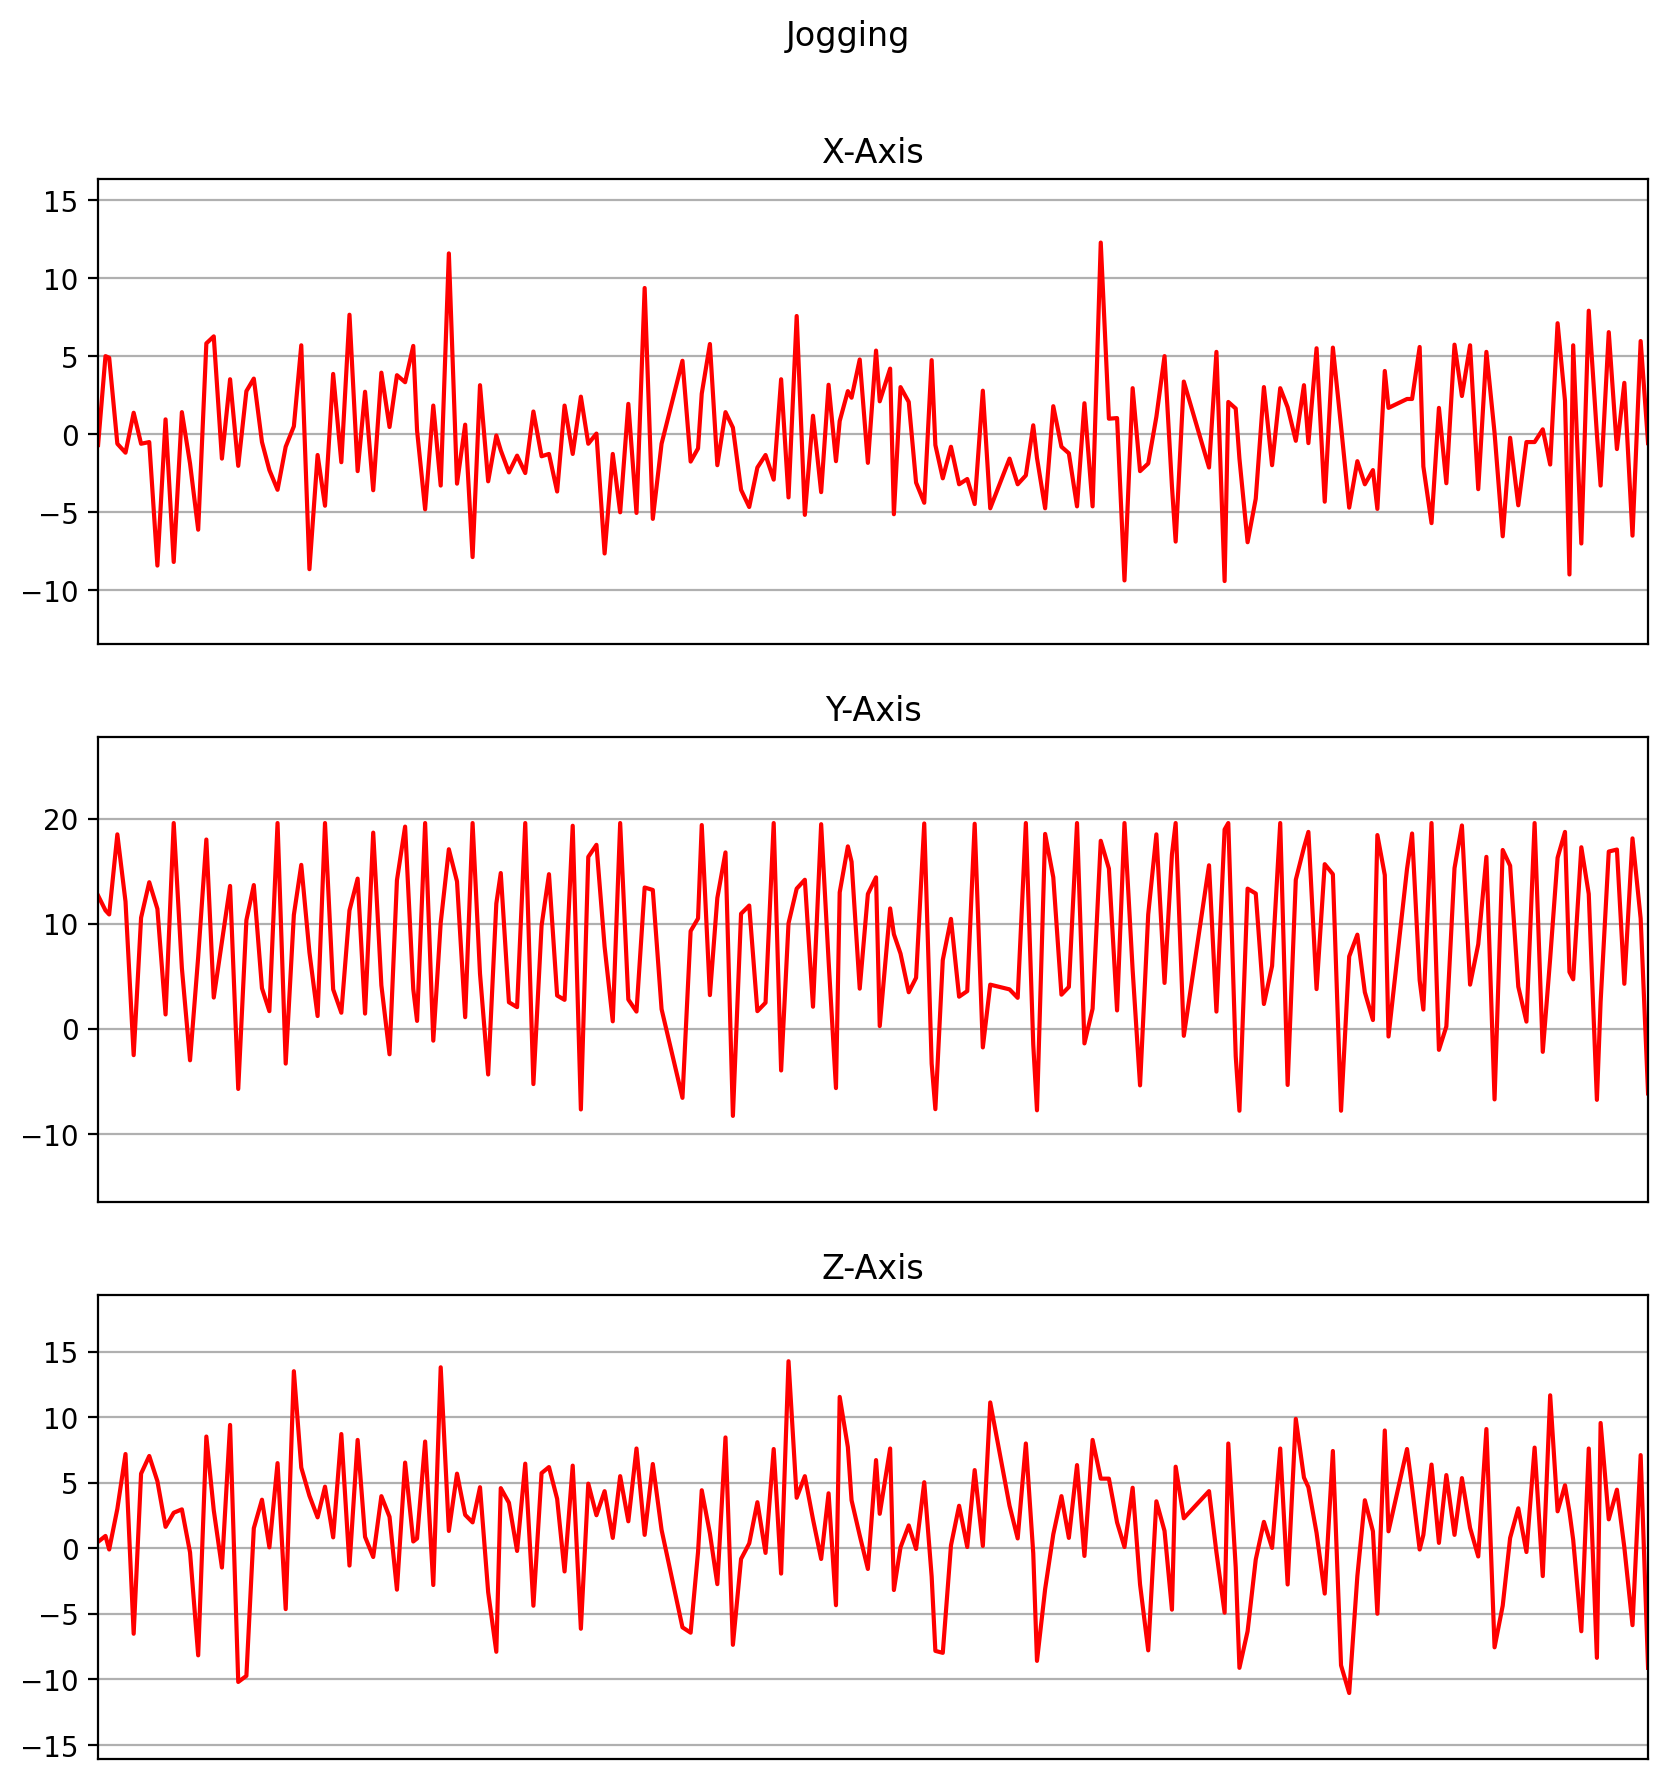

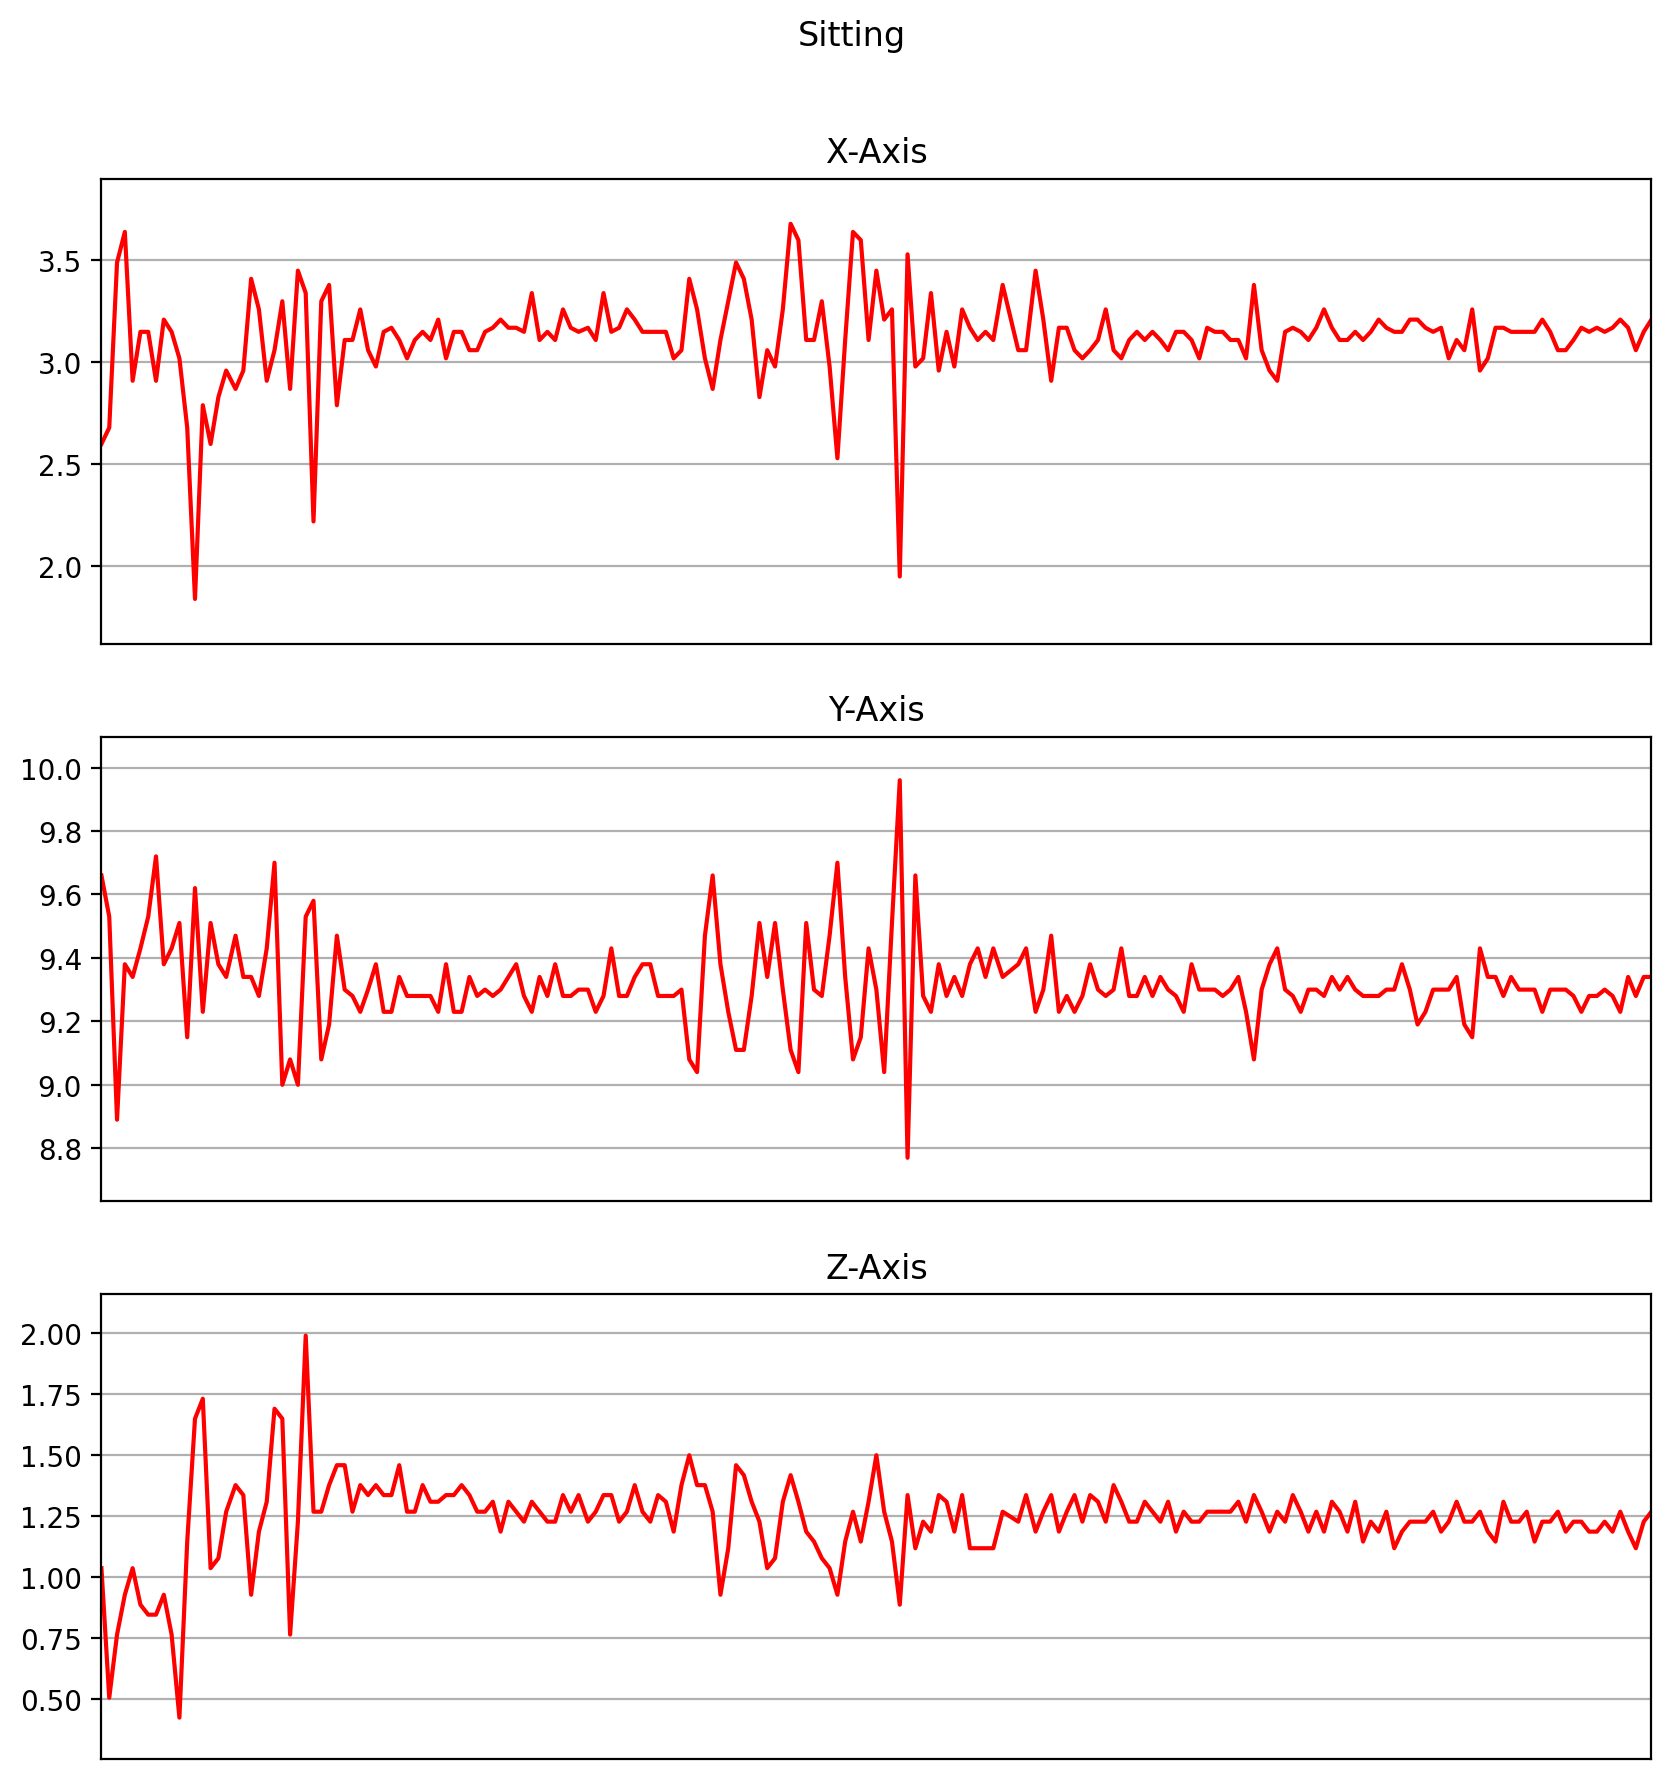

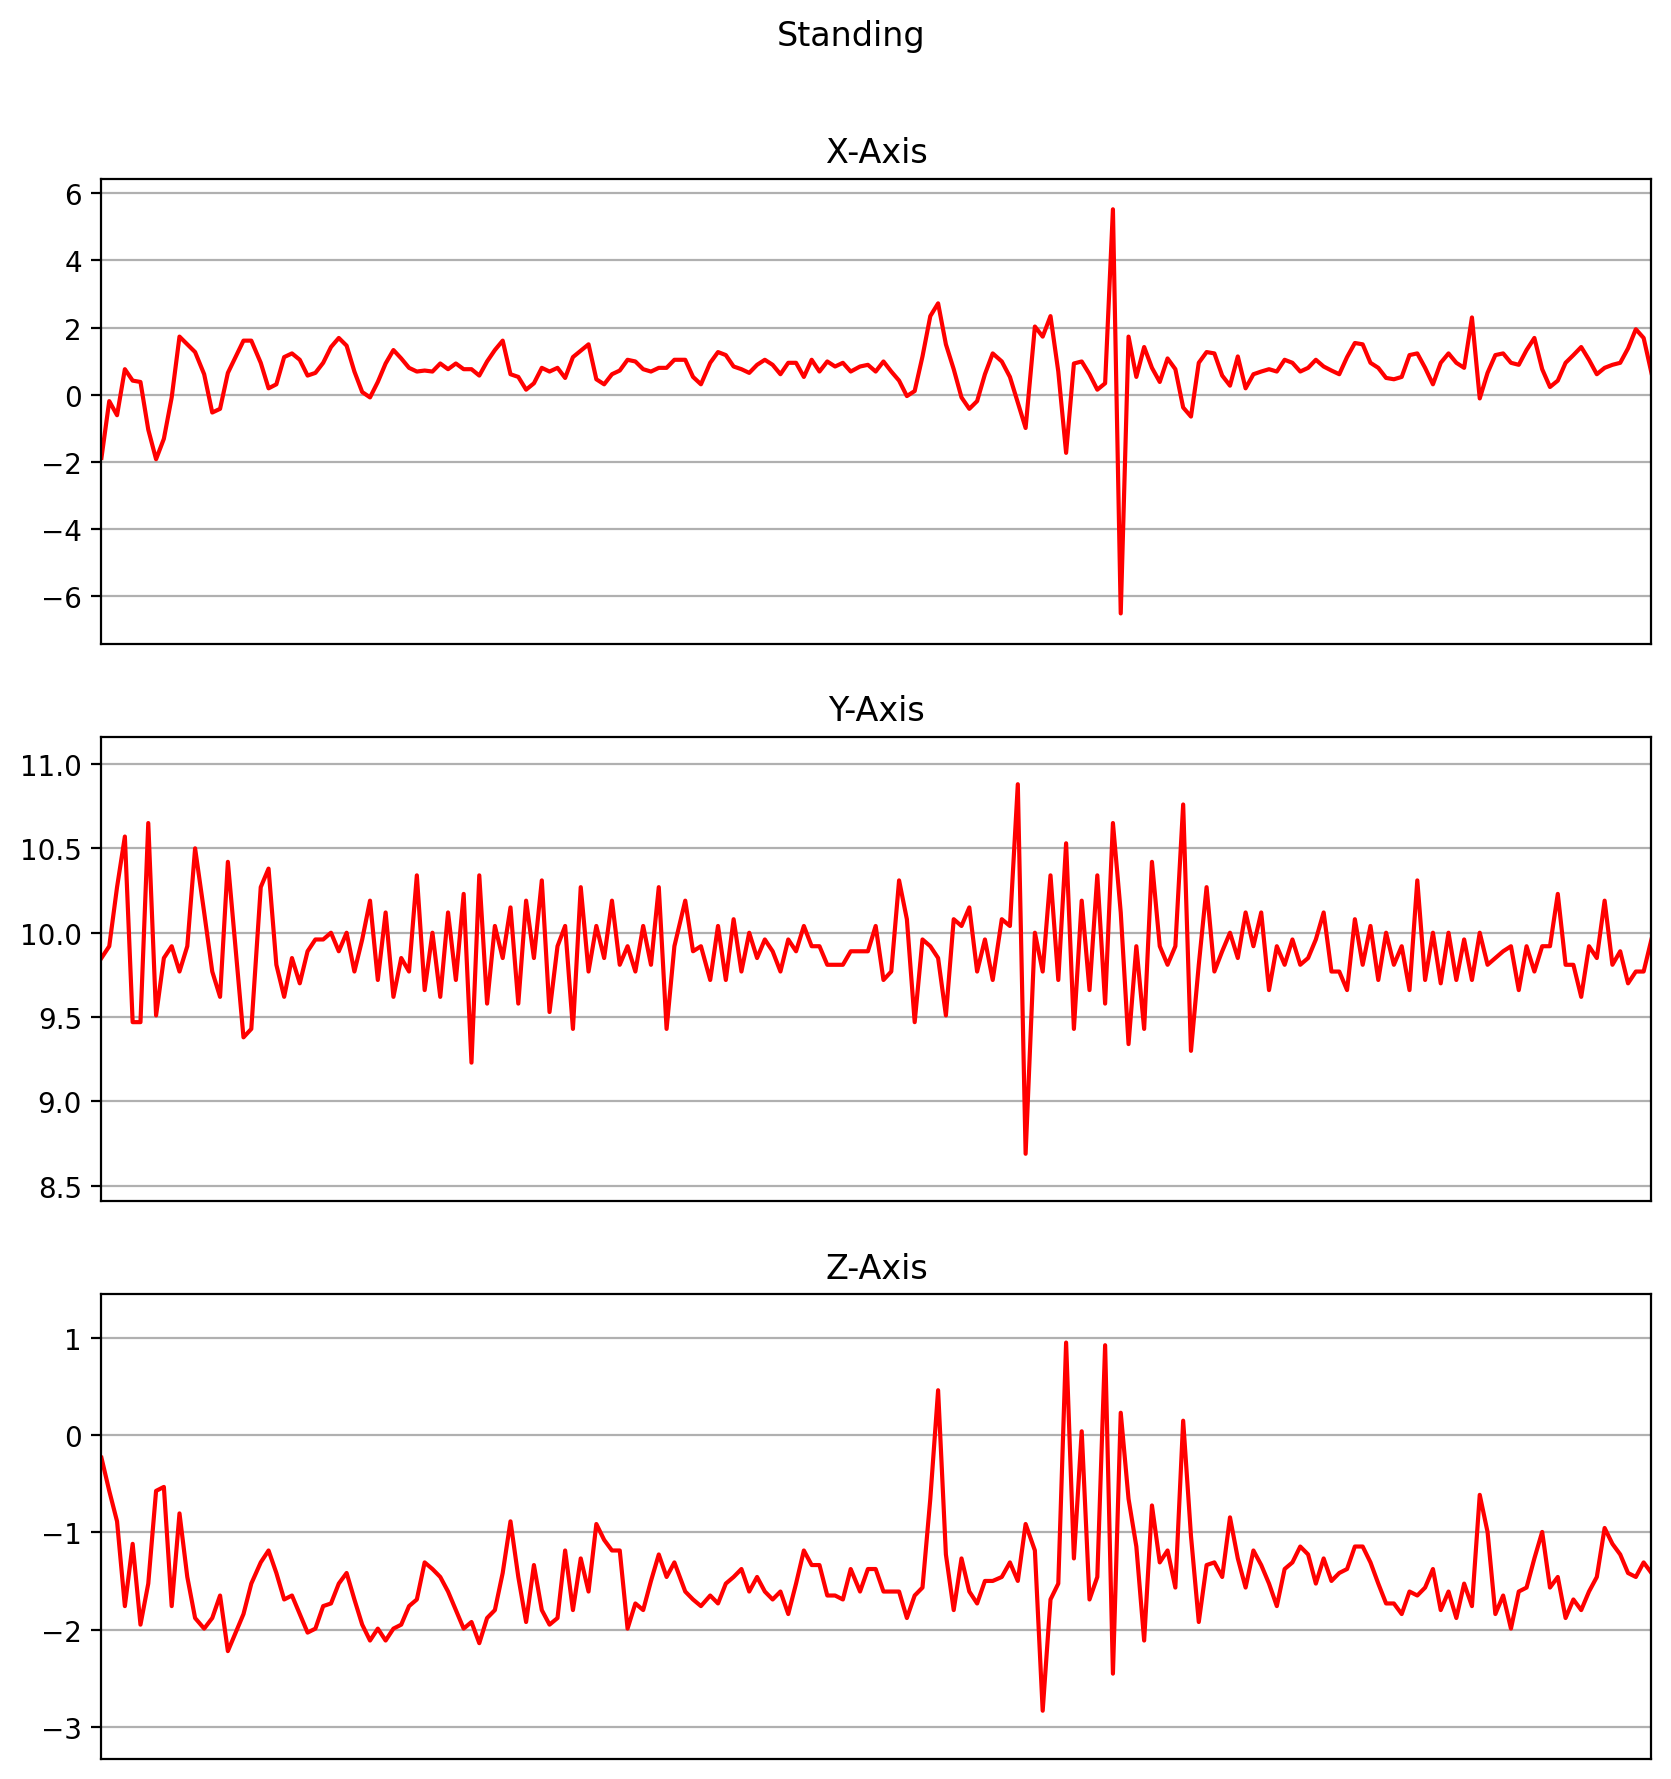

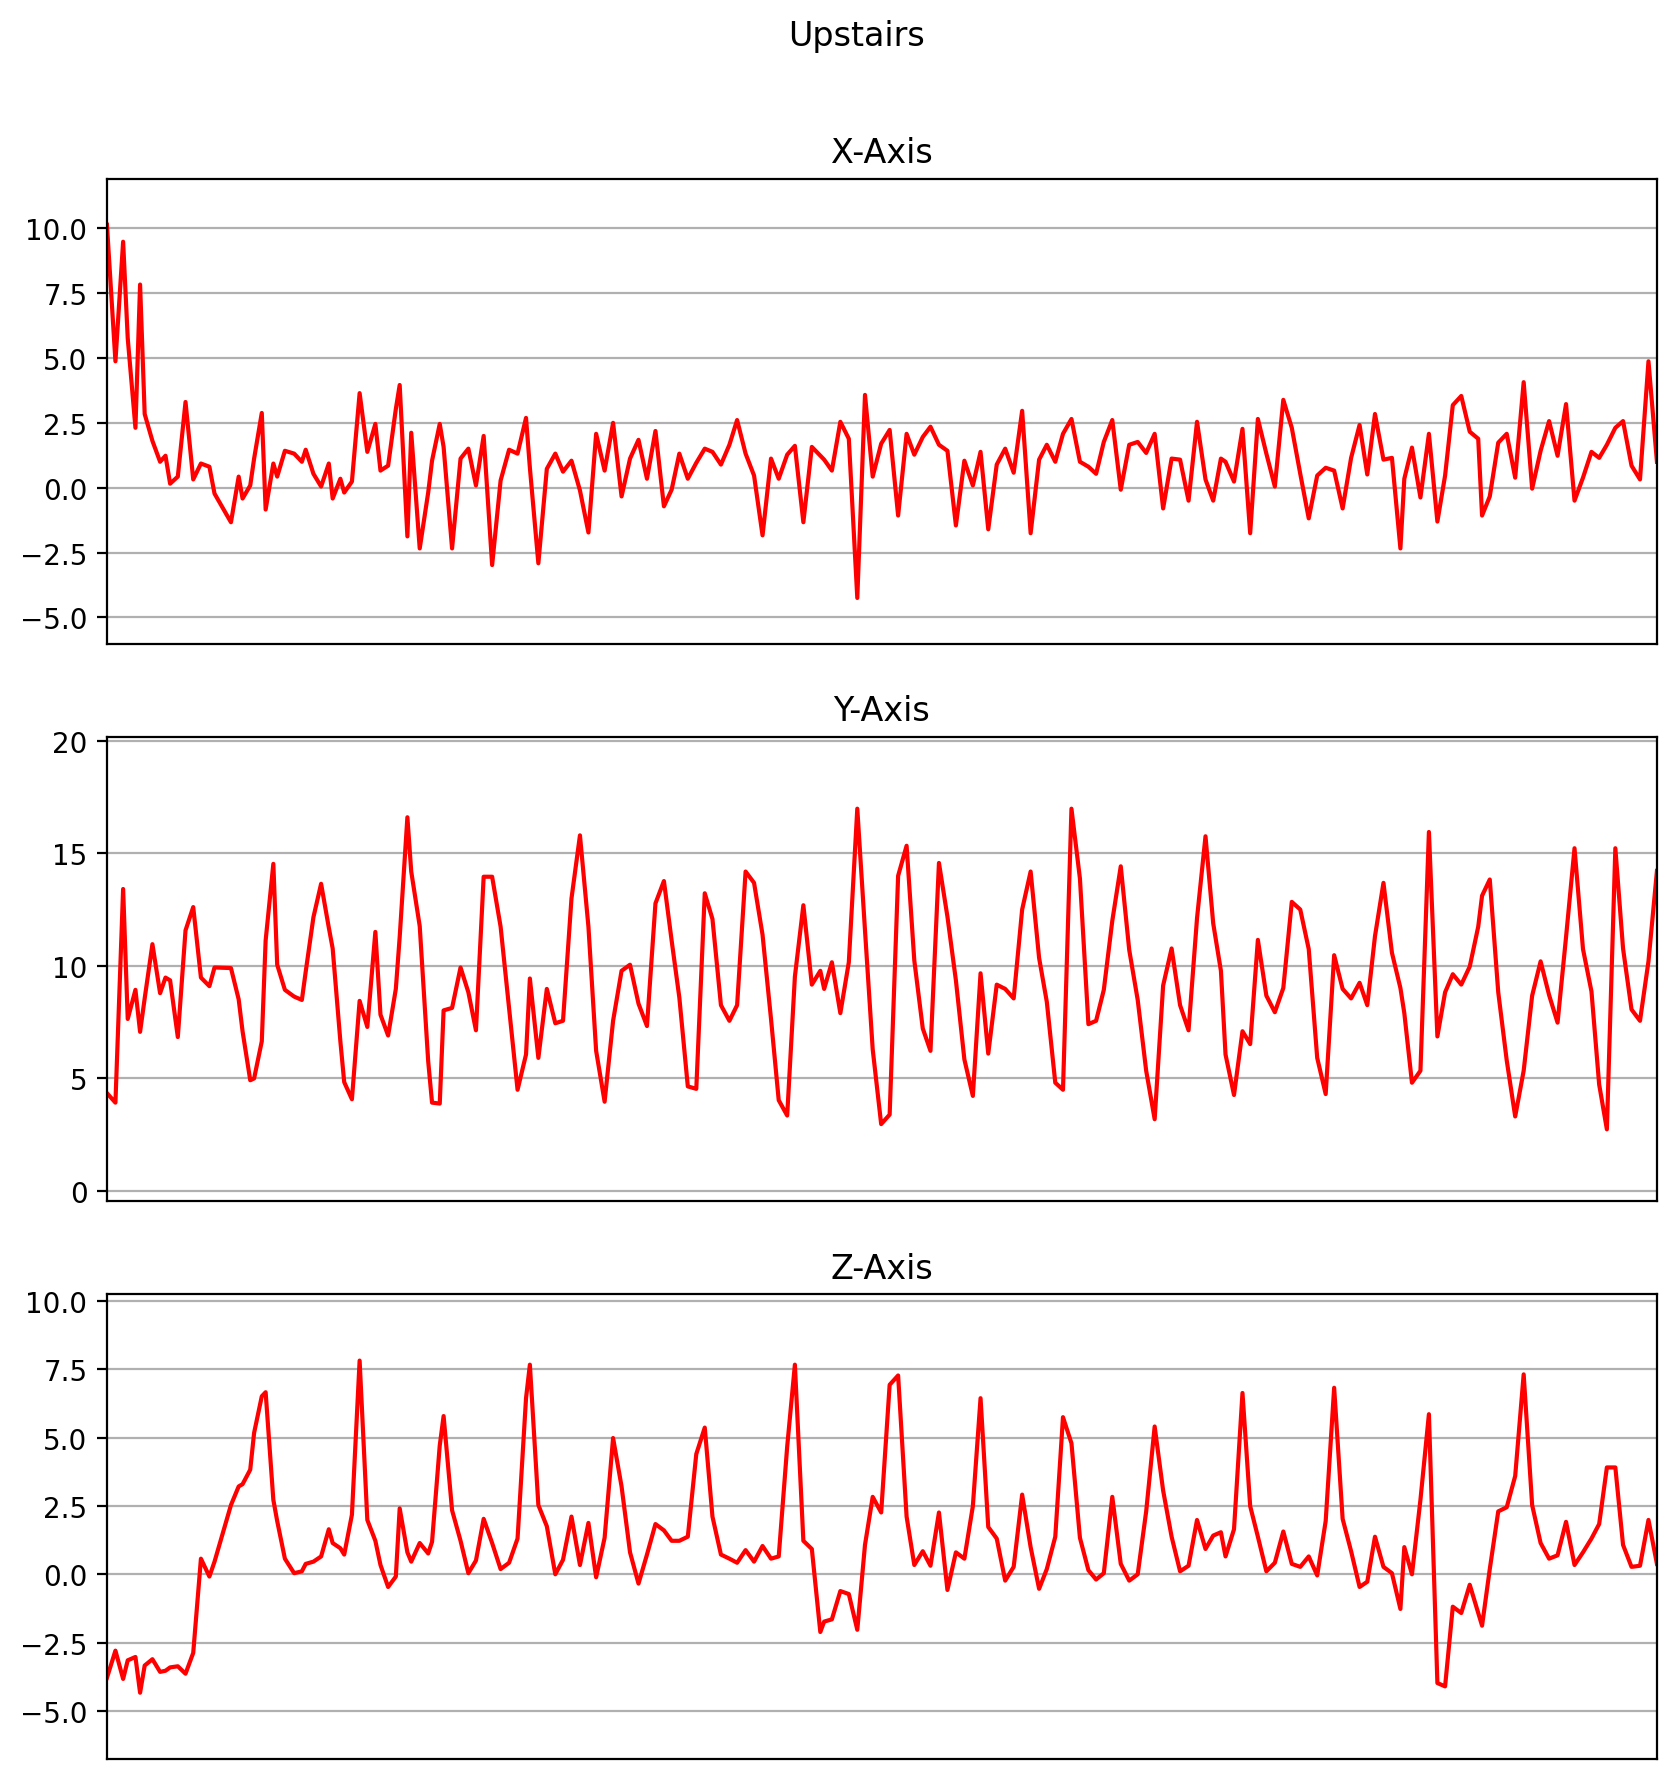

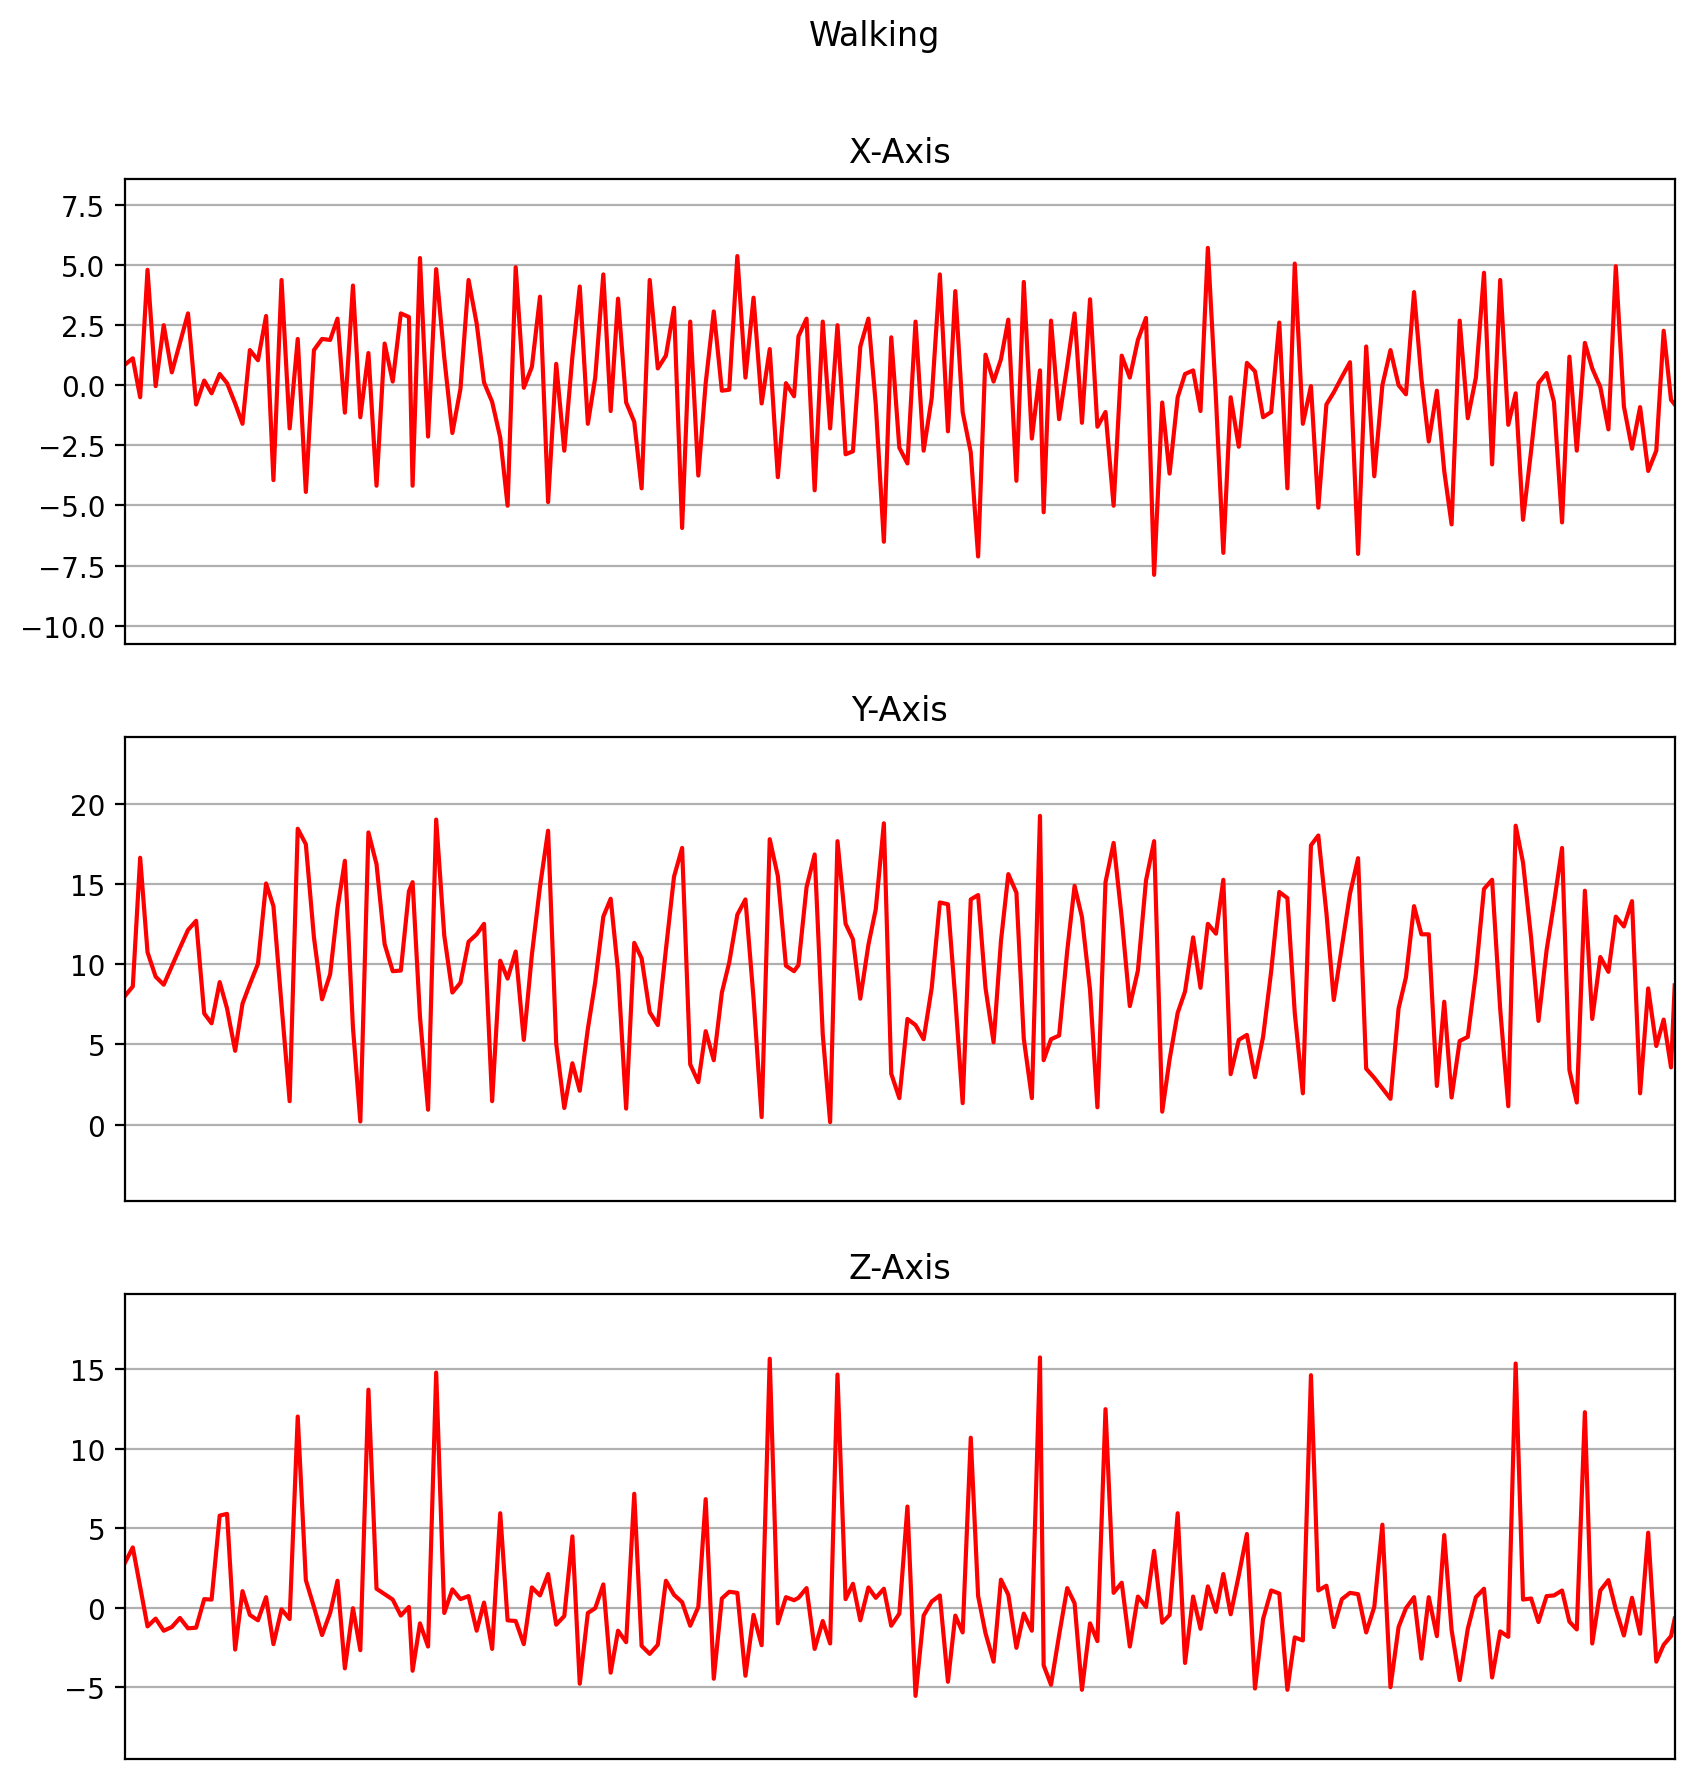

In [10]:
def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(10,10), sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:200]
    plot_activity(activity, subset)

In [12]:
le = preprocessing.LabelEncoder()
df['act'] = le.fit_transform(df['activity'].values)  #Jogging을 컴퓨터는 못알아보니까, act 컬럼에 레이블로 만들어줌.
df[:5]

,user-id,activity,timestamp,x-axis,y-axis,z-axis,act
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1
5,33,Jogging,49106442306000,1.375655,-2.492524,-6.510526,1
6,33,Jogging,49106542312000,-0.612916,10.569390,5.706926,1
7,33,Jogging,49106652389000,-0.503953,13.947236,7.055340,1
8,33,Jogging,49106762313000,-8.430995,11.413852,5.134871,1
9,33,Jogging,49106872299000,0.953424,1.375655,1.648062,1


# 판독 윈도우 크기
- 한가지 행동이 일정시간 동안 유지되어야 한다 (윈도우 크기)
- 데이터의 샘플링 간격은 50ms임
- 윈도우 크기를 100으로 잡으면 5초 동안 동일한 행동을 유지하는 경우만 취하게 됨
- stat 모듈이 제공하는 mode() 함수를 사용하여 최빈값을 구하고 이것이 100 인 경우의 데이터만 사용함 (동일한 행동을 5초간 유지하였는지를 파악함)
- 윈도우 크기를 얼마나 할지가 포인트임. (ex: 5초면 5초간의 좌표를 보고 행동을 판단하겠다는 얘기)
- 5초동안 자료를 보는데 조깅(5초)->조깅(5초)->조깅+워킹(5초)->워킹(5초).. 일때
  중간에 조깅+워킹(5초) 구간은 어떻게 할 것인가....... => 버려라. 애매한 데이터는 버리고 학습을 시켜야함.
  이처럼 데이터를 버리기 위해 mode를 사용.


In [14]:
test = [1,1,1,1,1,1,1,1,1,1,1,1,2,2]
m = stats.mode(test, keepdims=True) # 최빈값
m  #1 이란 값이 12번 나옴.(제일 많이 나온 값)

ModeResult(mode=array([1]), count=array([12]))

In [ ]:
m[1][0]

12

In [ ]:
m[0][0], m[1][0]

(1, 12)

In [17]:
z = stats.mode(df['act'][500:600], keepdims=True) # 5초간 관찰
z[0][0], z[1][0]  #500~600 구간에 97개만 조깅이고, 나머지는 다른 걸 했음.

(1, 97)

In [18]:
le.classes_  #0: Downstairs, 1 : Joiing, 2 : Sitting, 3 : Standing, 4: Upstairs, 5: Walking

array(['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
       'Walking'], dtype=object)

## 스케일링

In [19]:
sc = preprocessing.StandardScaler()
df[['x-axis', 'y-axis', 'z-axis']] = sc.fit_transform(df[['x-axis', 'y-axis', 'z-axis']])

In [ ]:
df[:5]

,user-id,activity,timestamp,x-axis,y-axis,z-axis,act
0,33,Jogging,49105962326000,-0.197590,0.794280,0.021188,1
1,33,Jogging,49106062271000,0.627483,0.583895,0.115037,1
2,33,Jogging,49106112167000,0.611730,0.527252,-0.101100,1
3,33,Jogging,49106222305000,-0.185775,1.658075,0.547311,1
4,33,Jogging,49106332290000,-0.268479,0.709317,1.420390,1


## 훈련-검증 데이터 나누기

- 아래는 임의로 id 번호를 기준으로 훈련-검증 데이터를 나누었다
  - id를 랜덤하게 섞어서 사용자를 선택하려면 random.choice() 사용한다
- 모든 사용자 데이터를 훈련-검증에 포함되게 하려면 전체 데이터를 대상으로 train_test_split()을 사용하면 된다

In [20]:
df_train = df[df['user-id'] < 28]
df_test = df[df['user-id'] >= 28]  #28 ID 기준으로 사용자 ID가 User-id <28 이하는 훈련데이터.

In [21]:
(df['user-id'] < 28).mean(), (df['user-id'] >= 28).mean()

(0.7382683047232287, 0.2617316952767713)

## X와 y 준비
- 훈련 및 검증 데이터에 대해서 X와 y를 구하는 함수 정의

In [31]:
def get_xy(N, df): # N: 윈도우 크기 (100)
    X, y = [], []
    for i in range(0, len(df)-N+1, N):
        z = stats.mode(df['act'][i: i+N], keepdims=True)
        action, count = z[0][0], z[1][0]
        if count == N:  #100개의 동일한 행동Label을 했으면
            xs = df['x-axis'].values[i: i + N]
            ys = df['y-axis'].values[i: i + N]
            zs = df['z-axis'].values[i: i + N]  #[i, [:3] ] 이런 식으로도 가능
            X.append(np.array([xs, ys, zs]).T)  #TransPose를 취해줌. 이걸 취하지 않으면 자료가 3X100 이됨. 이 소스로 인해서 100X3이 됨. 한단의 shape를 보면 이해될거임
            y.append(action)
    return np.array(X), np.array(y)

In [81]:
N = 200 #100-->200 으로 해본다 그러면 5초가 아니라 10초간격??
X_train, y_train = get_xy(N, df_train)
X_test,  y_test = get_xy(N, df_test)

In [78]:
X_train.shape, X_test.shape   #샘플수(요런게(100X3)이 몇 개 있냐) , 가운데는 샘플의 모양, 맨 끝은 샘플의 Feature 수

((15568, 50, 3), (5524, 50, 3))

In [34]:
X_train[:1]

array([[[-0.0144594 ,  0.36744014, -0.19494881],
        [-0.09716361,  0.42408248, -0.20348053],
        [-0.13063913,  0.37350895, -0.22907568],
        [-0.07550298,  0.40789908, -0.189261  ],
        [-0.07550298,  0.41801367, -0.21201225],
        [-0.00855196,  0.3896925 , -0.22907568],
        [-0.08141043,  0.39576131, -0.189261  ],
        [-0.11291679,  0.40183027, -0.19494881],
        [-0.1089785 ,  0.41396789, -0.16366584],
        [-0.05187321,  0.39576131, -0.21201225],
        [-0.04793491,  0.39576131, -0.20348053],
        [-0.04202747,  0.40789908, -0.19494881],
        [-0.05778065,  0.40183027, -0.189261  ],
        [-0.04202747,  0.39576131, -0.21201225],
        [-0.02430514,  0.40183027, -0.21201225],
        [-0.03021258,  0.39576131, -0.17219756],
        [-0.02430514,  0.39576131, -0.17219756],
        [-0.04202747,  0.39576131, -0.15513413],
        [-0.05187321,  0.3896925 , -0.16366584],
        [-0.02036684,  0.3896925 , -0.17219756],
        [-0.02036684

In [27]:
y_train.shape, y_test.shape

((7637,), (2713,))

## 결과 보기

- 6x6 혼돈 매트릭스를 그려야 한다

In [79]:
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']

In [36]:
def show_confusion_matrix(y_test, y_pred):
    matrix = metrics.confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [37]:
def show_results(y_test, y_pred):
    show_confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred))

# 선형 분류

-  위 자료에 대해서 가장 간단해서 먼저 시도해볼게요..

In [38]:
lin = SGDClassifier()
lin.fit(X_train.reshape(-1,300), y_train)   #1줄짜리 테이블을 만듬 100*3 을 컬럼이 300개짜리인 row로 만들어버림.
lin.score(X_test.reshape(-1,300), y_test)   #결과가 0.45(약 45%)가 나옴. 총6개의 행동에 대해서 판단을 하는건데 평균..보다는 나음.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


0.4548470328050129

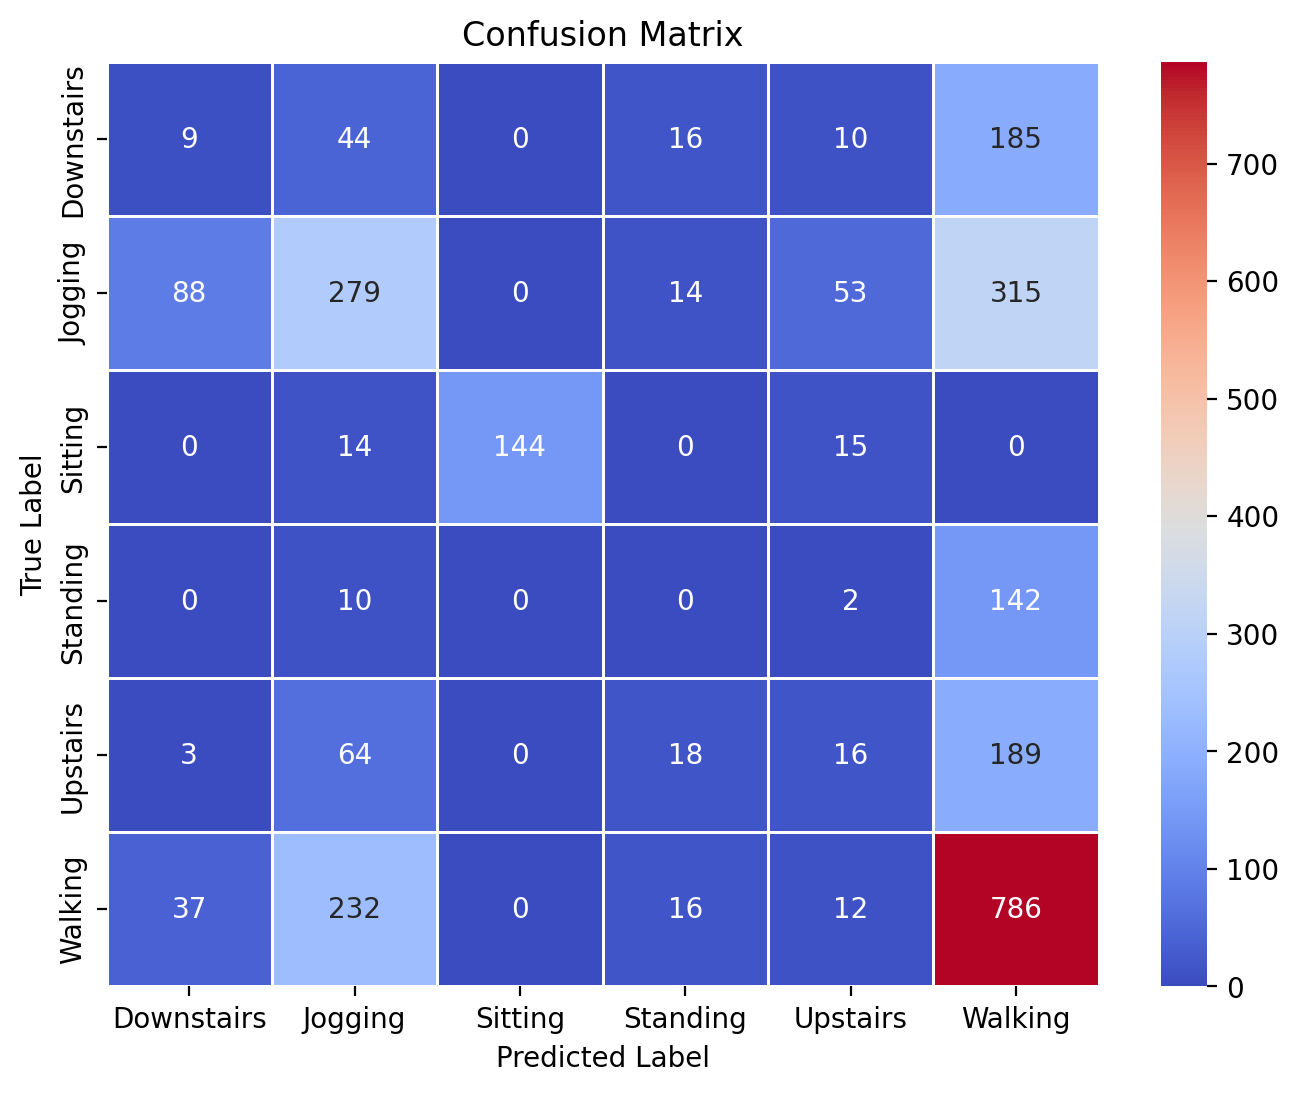

              precision    recall  f1-score   support

           0       0.07      0.03      0.04       264
           1       0.43      0.37      0.40       749
           2       1.00      0.83      0.91       173
           3       0.00      0.00      0.00       154
           4       0.15      0.06      0.08       290
           5       0.49      0.73      0.58      1083

    accuracy                           0.45      2713
   macro avg       0.36      0.34      0.34      2713
weighted avg       0.40      0.45      0.41      2713



In [39]:
y_pred = lin.predict(X_test.reshape(-1,300))
show_results(y_test, y_pred)
#6개를 분류하면 6X6 의 매트릭스가 나옴. Y(왼쪽)은 TRUE고 X(아래축)은 Predic

# 랜덤 포레스트

In [40]:
rfc = RandomForestClassifier()
rfc.fit(X_train.reshape(-1,300), y_train)
rfc.score(X_test.reshape(-1,300), y_test)

0.7386656837449318

In [42]:
X_train.reshape(-1,300)

array([[-0.0144594 ,  0.36744014, -0.19494881, ...,  0.00326293,
         0.91970261,  1.54836579],
       [ 0.14701073,  0.39576131, -0.61869085, ...,  0.19033199,
         0.70324812,  1.05921395],
       [-0.17396038,  0.03163222,  0.05247104, ...,  0.19623943,
         0.80034926, -0.48502726],
       ...,
       [ 1.19821928, -1.24354044,  0.38784785, ...,  1.2097852 ,
        -1.3222578 ,  0.24377698],
       [ 1.3080955 , -1.21383577,  0.23542504, ...,  1.18665336,
        -1.2777008 ,  0.37949592],
       [ 1.19243632, -1.27175987,  0.40455172, ...,  1.19243632,
        -1.2866122 ,  0.37114398]])

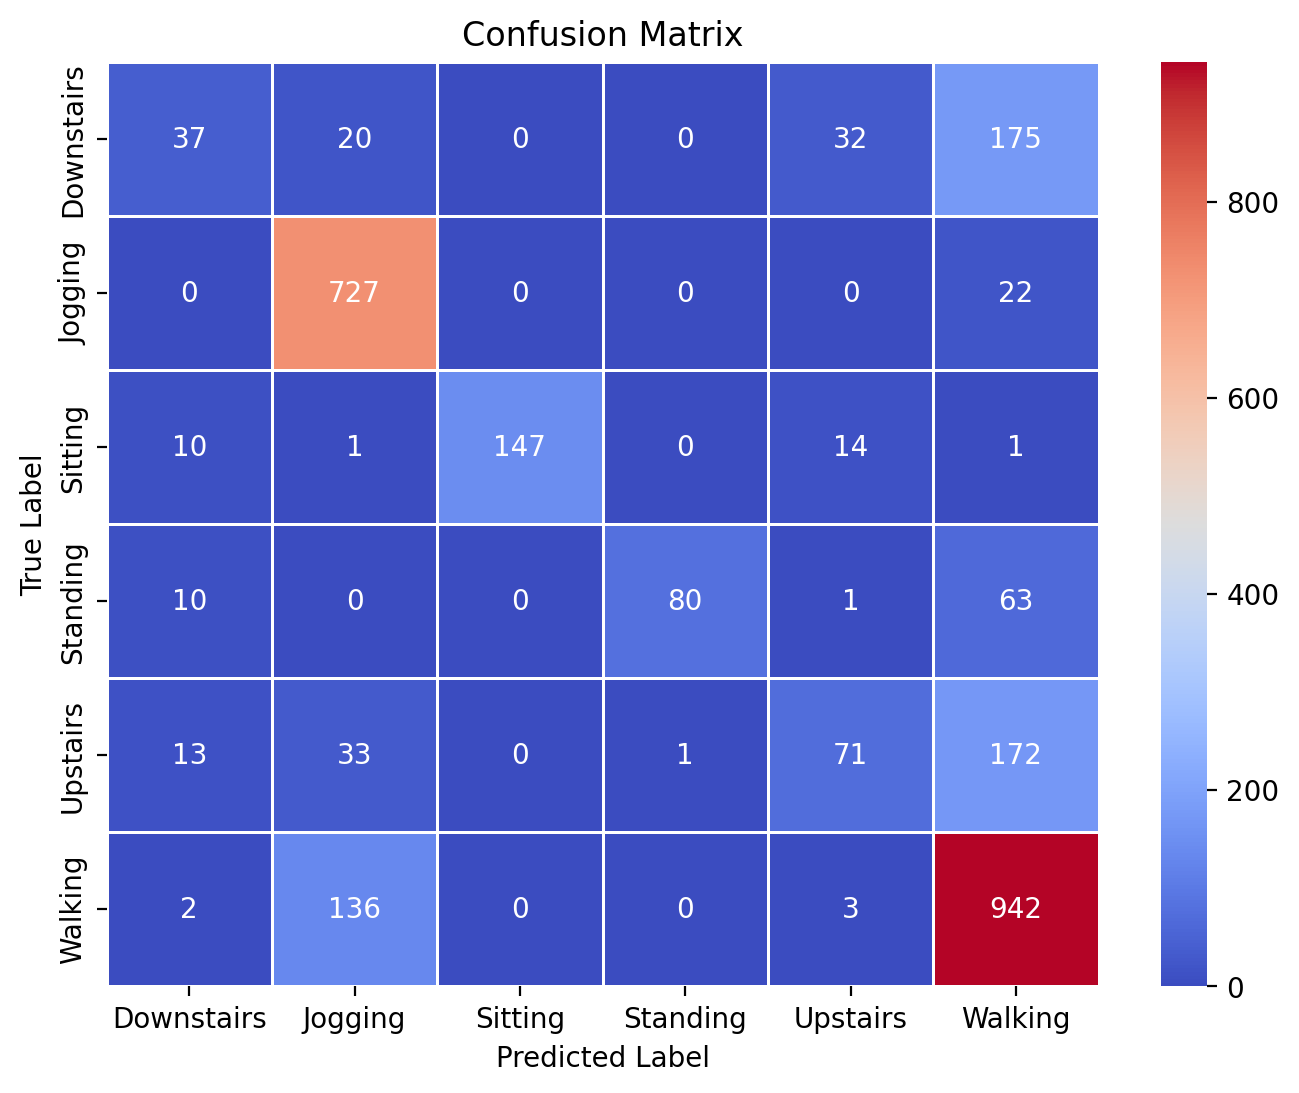

              precision    recall  f1-score   support

           0       0.51      0.14      0.22       264
           1       0.79      0.97      0.87       749
           2       1.00      0.85      0.92       173
           3       0.99      0.52      0.68       154
           4       0.59      0.24      0.35       290
           5       0.69      0.87      0.77      1083

    accuracy                           0.74      2713
   macro avg       0.76      0.60      0.63      2713
weighted avg       0.72      0.74      0.70      2713



In [43]:
y_pred = rfc.predict(X_test.reshape(-1,300))
show_results(y_test, y_pred)

# MLP

## 목적변수 원핫 인코딩
- 신경망은 분류시 레이블을 원핫 인코딩해야 한다

In [44]:
# 원 핫 인코딩
y_train_cat = to_categorical(y_train)  #목적변수를 원핫인코딩
y_test_cat = to_categorical(y_test)
y_train_cat[:10]   #0: Downstairs, 1 : Joiing, 2 : Sitting, 3 : Standing, 4: Upstairs, 5: Walking  이니까 6번째면 Walking 일듯.

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

## MLP 모델 정의

In [45]:
model_m = Sequential()
model_m.add(Reshape((N*3,),input_shape=(N,3)))
model_m.add(Dense(200, activation='relu',input_shape=(N*3,)))
model_m.add(Dropout(0.5))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(6, activation='softmax'))

In [46]:
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

h = model_m.fit(X_train,
                      y_train_cat,
                      batch_size=20,
                      epochs=30,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=0)

85/85 [==============================] - 0s 2ms/step


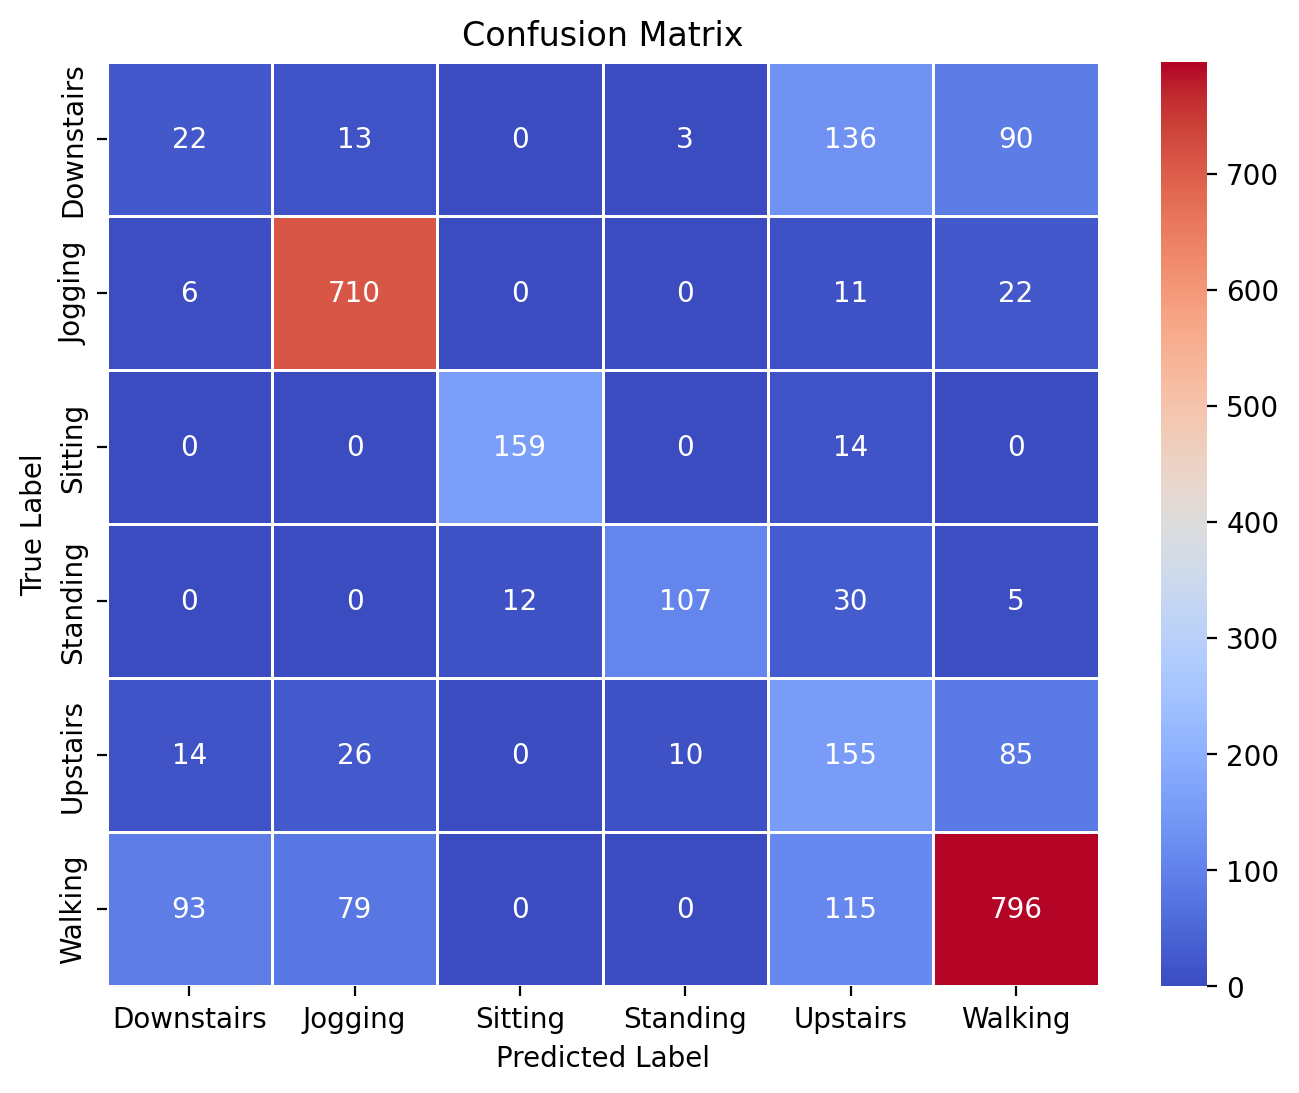

              precision    recall  f1-score   support

           0       0.16      0.08      0.11       264
           1       0.86      0.95      0.90       749
           2       0.93      0.92      0.92       173
           3       0.89      0.69      0.78       154
           4       0.34      0.53      0.41       290
           5       0.80      0.73      0.77      1083

    accuracy                           0.72      2713
   macro avg       0.66      0.65      0.65      2713
weighted avg       0.72      0.72      0.71      2713



In [47]:
y_pred = model_m.predict(X_test)

max_y_pred = np.argmax(y_pred, axis=1) #argmax를 써서 확률이 제일 큰 걸 뽑아야 그 값이 우리가 생각한 Y Predic 임.
show_results(y_test, max_y_pred)

In [48]:
def show_4_graphs(history):
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
    plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
    plt.plot(history.history['loss'], 'r--', label='Loss of training data')
    plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
    plt.title('Model Accuracy and Loss')
    plt.ylabel('Accuracy and Loss')
    plt.xlabel('Training Epoch')
    plt.ylim(0)
    plt.legend()
    plt.show()

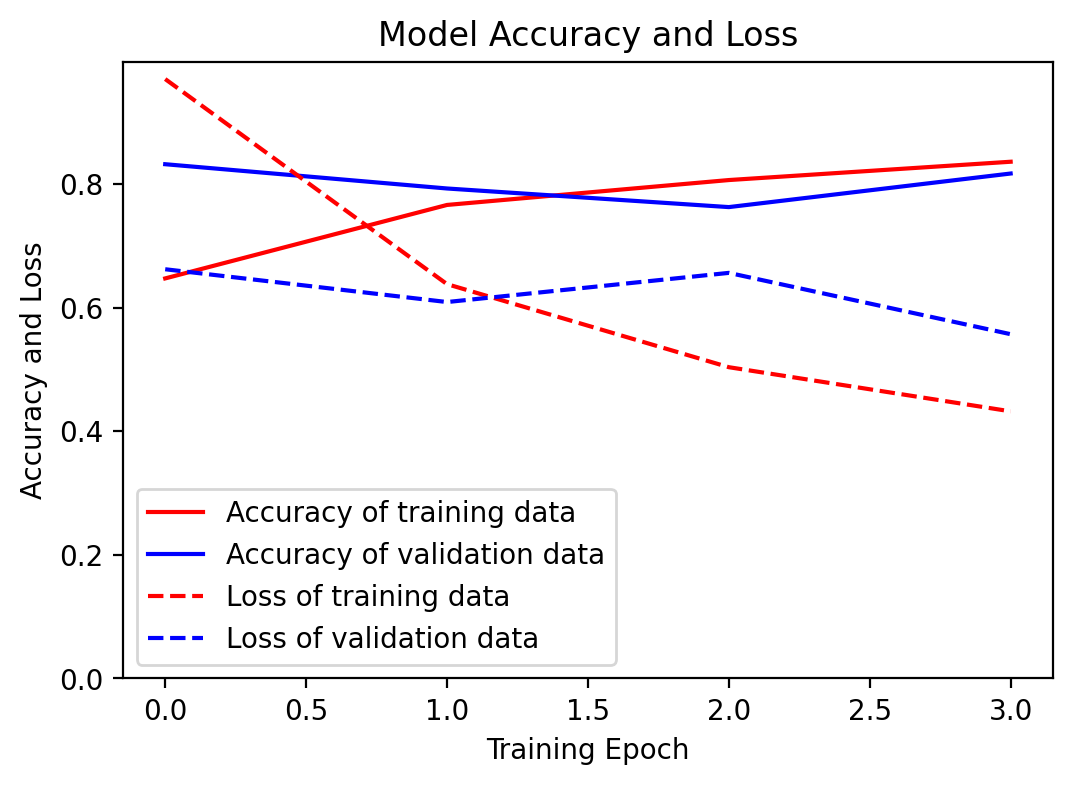

In [49]:
show_4_graphs(h)

# CNN (Conv1D)

- 시계열 패턴 분석에는 1차원 컨볼류션을 사용한다

In [80]:
# (sample, shape, features) 구조 사용, shape=(N,) 인 1차원 어레이
model_cnn = Sequential()
model_cnn.add(Conv1D(32, 4, activation='relu',input_shape=(N,3)))  #기존에는 filter를 32,4,4 라는 식으로 2차원 필터를 만들었었음..
model_cnn.add(Dropout(0.3))
model_cnn.add(Conv1D(32, 4, activation='relu'))
model_cnn.add(MaxPooling1D(2))                                     #MaxPooling도 1D로 함. MaxPooling(2)는 한 번 씩 할 때마다 반씩 줄어듬.
model_cnn.add(Conv1D(64, 4, activation='relu'))
model_cnn.add(Dropout(0.3))
model_cnn.add(MaxPooling1D(2))

model_cnn.add(Conv1D(64, 4, activation='relu'))
model_cnn.add(MaxPooling1D(2))
model_cnn.add(Conv1D(128, 4, activation='relu'))
model_cnn.add(MaxPooling1D(2))

model_cnn.add(Flatten())
model_cnn.add(Dropout(0.3))
model_cnn.add(Dense(6, activation='softmax'))
model_cnn.summary()

ValueError: ignored

In [76]:
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
model_cnn.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

history = model_cnn.fit(X_train,
                      y_train_cat,
                      batch_size=30,
                      epochs=50,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

#만약 사람단위로 끊어서 하면 99%나올거임.


Epoch 1/50
98/98 [==============================] - 4s 10ms/step - loss: 1.3391 - accuracy: 0.4395 - val_loss: 1.5938 - val_accuracy: 0.2867
Epoch 2/50
98/98 [==============================] - 1s 6ms/step - loss: 1.2718 - accuracy: 0.4701 - val_loss: 1.6103 - val_accuracy: 0.2500
Epoch 3/50
98/98 [==============================] - 1s 6ms/step - loss: 1.2268 - accuracy: 0.4816 - val_loss: 1.5448 - val_accuracy: 0.4810
Epoch 4/50
98/98 [==============================] - 1s 6ms/step - loss: 1.1685 - accuracy: 0.5139 - val_loss: 1.6748 - val_accuracy: 0.3016
Epoch 5/50
98/98 [==============================] - 1s 6ms/step - loss: 1.0662 - accuracy: 0.5534 - val_loss: 1.7830 - val_accuracy: 0.3899
Epoch 6/50
98/98 [==============================] - 1s 6ms/step - loss: 0.9954 - accuracy: 0.5816 - val_loss: 1.5730 - val_accuracy: 0.3859


85/85 [==============================] - 0s 3ms/step


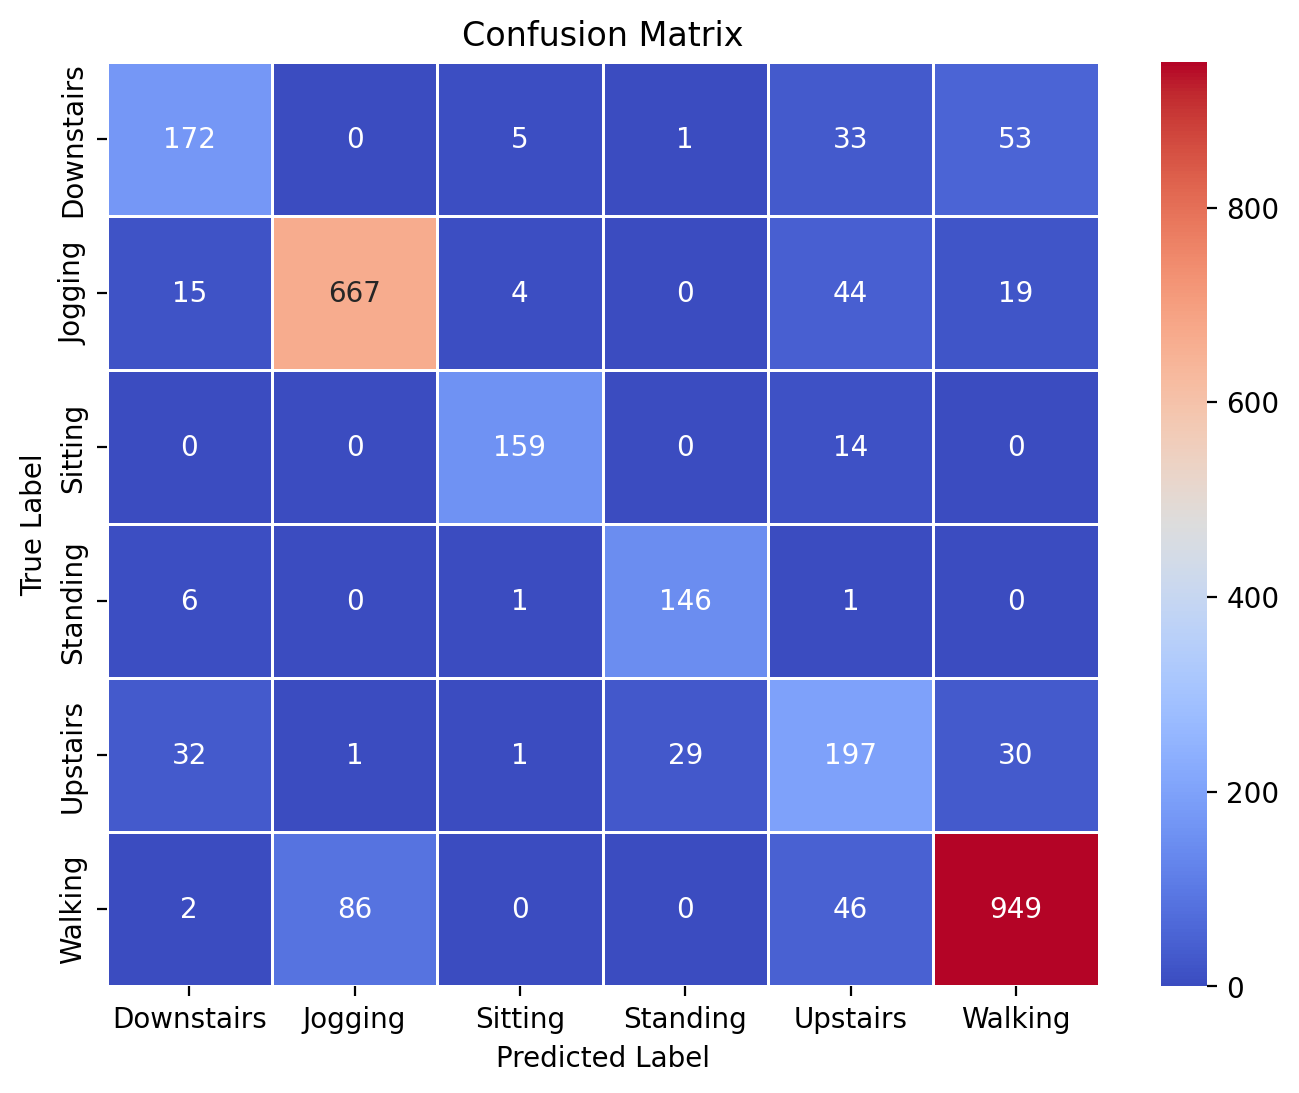

              precision    recall  f1-score   support

           0       0.76      0.65      0.70       264
           1       0.88      0.89      0.89       749
           2       0.94      0.92      0.93       173
           3       0.83      0.95      0.88       154
           4       0.59      0.68      0.63       290
           5       0.90      0.88      0.89      1083

    accuracy                           0.84      2713
   macro avg       0.82      0.83      0.82      2713
weighted avg       0.85      0.84      0.84      2713



In [53]:
y_pred = model_cnn.predict(X_test)

max_y_pred = np.argmax(y_pred, axis=1)
show_results(y_test, max_y_pred)

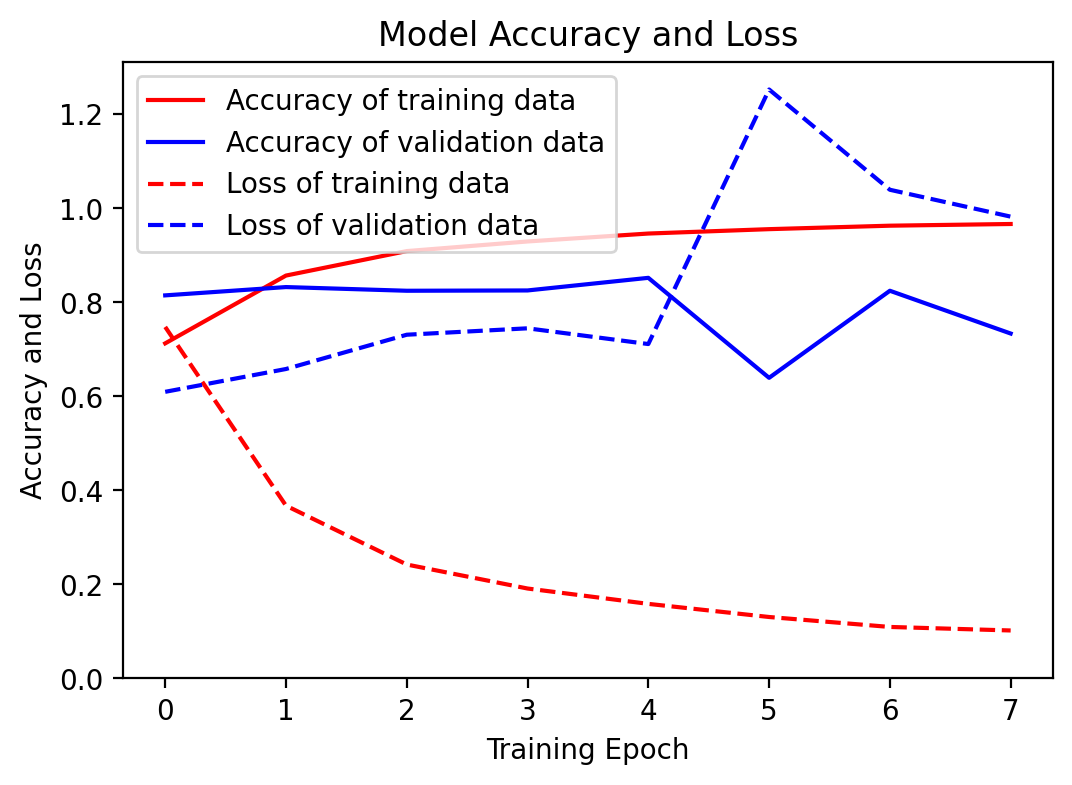

In [54]:
show_4_graphs(history)